### Imports

In [1]:
!pip install fasttext

!pip install transformers

!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 68 kB 2.9 MB/s 
  Using cached pybind11-2.9.0-py2.py3-none-any.whl (210 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3129963 sha256=63886d4d5a85c9f0969dbcf40acd37f14224ade0989bf9965e5410143aa18249
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 61 kB 500 kB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
     |████████████████████████████████| 596 kB 49.4 MB/s 
     |████████████████████████████████| 895 kB 46.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 58 kB 2.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=5619

In [2]:
import numpy as np
import pandas as pd

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,  AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

### Downloading data

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [4]:
! kaggle competitions download -c nlp-2021-hw1

!unzip nlp-2021-hw1.zip

  0% 0.00/1.62M [00:00<?, ?B/s]
100% 1.62M/1.62M [00:00<00:00, 148MB/s]
Archive:  nlp-2021-hw1.zip
  inflating: test.tsv                
  inflating: train.tsv               
  inflating: valid.tsv               


### Parameters


In [5]:
MAX_LEN = 100
RANDOM_SEED = 42
BATCH_SIZE = 32

EPOCHS = 5
LEARNING_RATE = 5e-4

## Tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained("cimm-kzn/rudr-bert")

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/521 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Dataset

In [7]:
train_df = pd.read_csv('train.tsv', sep='\t')
eval_df = pd.read_csv('test.tsv', sep='\t')
val_df = pd.read_csv('valid.tsv', sep='\t')

# train_positive_class_df = train_df[train_df['label'] == 1]
# train_negative_class_df = train_df[train_df['label'] == 0]

# num_positive_examples = len(train_positive_class_df)

# train_negative_class_df = train_negative_class_df.sample(num_positive_examples)
# train_df = pd.concat((train_positive_class_df, train_negative_class_df)).sample(frac=1)

In [8]:
class HWDataset(Dataset):
  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(label, dtype=torch.long)
    }
    

In [9]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = HWDataset(
    tweets=df.tweet.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [11]:
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

### Model

In [12]:
class ADRClassifier(nn.Module):

  def __init__(self, n_classes):
    super(ADRClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained("cimm-kzn/rudr-bert")
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs["pooler_output"])
    return self.out(output)

In [13]:
model = ADRClassifier(2)
model = model.to(device)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at cimm-kzn/rudr-bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training:

In [14]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_df)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.3999473293115443 accuracy 0.8835532746823069
Val   loss 0.4111385286561455 accuracy 0.9127007299270073

Epoch 2/5
----------
Train loss 0.34601617173757404 accuracy 0.9046920821114369
Val   loss 0.33577136172809535 accuracy 0.9127007299270073

Epoch 3/5
----------
Train loss 0.3339831538614817 accuracy 0.9053030303030303
Val   loss 0.30458947929933117 accuracy 0.9127007299270073

Epoch 4/5
----------
Train loss 0.33016182664141525 accuracy 0.9055474095796676
Val   loss 0.30502244309280757 accuracy 0.9127007299270073

Epoch 5/5
----------
Train loss 0.3263749485195149 accuracy 0.9055474095796676
Val   loss 0.2957930225465033 accuracy 0.9127007299270073

CPU times: user 26min 2s, sys: 44.8 s, total: 26min 47s
Wall time: 26min 55s


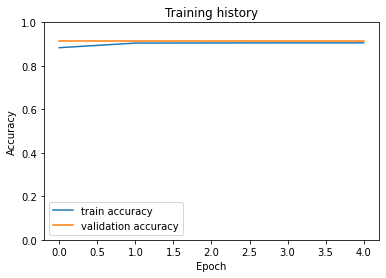

In [18]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Predicting labels for valid and test sets:

In [19]:
eval_df['label'] = 0

eval_data_loader = create_data_loader(eval_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [21]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
    eval_data_loader
)
y_pred_probs = y_pred_probs.tolist()

In [22]:
res_dict = {'tweet': y_review_texts, 'label': [a[1] for a in y_pred_probs]} 

res = pd.DataFrame(res_dict)

In [23]:
submit_df = pd.merge(left=res, right=eval_df.drop(columns=['label']), on='tweet').drop(columns=['tweet'])[['tweet_id', 'label']]

In [24]:
submit_df.to_csv('solution.csv', sep=',', index=False)

In [25]:
print([a[1] for a in y_pred_probs])
print(y_pred)

[0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210587084293365, 0.10210587084293365, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210587084293365, 0.10210587084293365, 0.10210587084293365, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.10210587084293365, 0.10210588574409485, 0.10210588574409485, 0.10210588574409485, 0.1021058857